In [2]:
import numpy as np
import matplotlib.pyplot as plt

import green2

import math

from BachataClass import *


def calculation_velocities(Z1, Z2, property_data):
    property_data_depths = np.unique(np.array([float(line.split()[1]) for line in property_data]))

    prop_data = property_data[np.abs(Z1 - property_data_depths).argmin():np.abs(Z2 - property_data_depths).argmin() + 1]

    Vp, Vs = [], []
    for i in range(len(prop_data)):
        vp, vs = list(map(lambda x: float(x), prop_data[i].split()[-2:]))
        Vp.append(vp)
        Vs.append(vs)

    Vp, Vs = np.mean(Vp), np.mean(Vs)

    return Vp, Vs


def calc_r(x, y):
    return np.sqrt(x ** 2 + y ** 2)


with open("property.txt", "r") as f:
    property_data = f.readlines()
f.close()

with open("sensors_413.txt", "r") as f:
    sensors = f.readlines()
f.close()

with open("413_inkl_point.txt", "r") as f:
    inkl = f.readlines()
f.close()

inkl_data = []
for i in range(1, len(inkl)):
    inkl_data.append(list(map(lambda x: float(x), inkl[i].split("\t"))))

inkl_data = np.array(inkl_data)
sensors_depths = []
for line in sensors[8:]:  # 415 c 6, 413 c 8
    line = line.split()
    sensors_depths.append([int(line[0]), int(line[2]) / 100])

sensors_depths = np.array(sensors_depths)
sensors_depths_unique = np.unique(sensors_depths[:, 1])

half_well = sensors_depths[:sensors_depths.shape[0] // 2, :]

old_well = []
for i in range(inkl_data.shape[0]):
    R = calc_r(inkl_data[i, 3], inkl_data[i, 4])
    TVD = inkl_data[i, 1]

    old_well.append([R, TVD])

old_well = np.array(old_well)

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(old_well[:, 0], old_well[:, 1], label='old')
# ax.set_xlabel('R')
# ax.set_ylabel('TVD')
# ax.set_title('Вид сбоку')
# plt.gca().invert_yaxis()
# ax.set_aspect(1)
# plt.legend()
# plt.show()

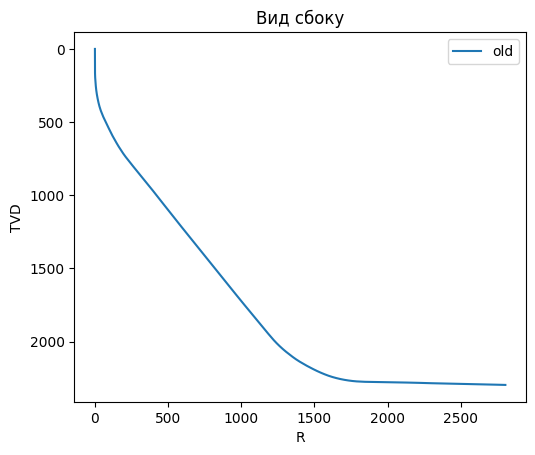

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(old_well[:, 0], old_well[:, 1], label='old')
ax.set_xlabel('R')
ax.set_ylabel('TVD')
ax.set_title('Вид сбоку')
plt.gca().invert_yaxis()
ax.set_aspect(1)
plt.legend()
plt.show()

In [8]:
# ----------------ROTATION---------------------------------
depth_ind = 1572
depth = half_well[depth_ind, 1]

ind = np.abs(inkl_data[:, 0] - depth).argmin()

R_sens0 = calc_r(inkl_data[ind, 3], inkl_data[ind, 4])
R_sens1 = calc_r(inkl_data[ind + 1, 3], inkl_data[ind + 1, 4])
z_sens0 = inkl_data[ind, 1]
z_sens1 = inkl_data[ind + 1, 1]

z_tvd0, z_tvd1 = inkl_data[ind, 1], inkl_data[ind + 1, 1]

sens_vect = np.sqrt((R_sens1 - R_sens0) ** 2 + (z_sens1 - z_sens0) ** 2)
tvd_vect = np.sqrt((z_tvd1 - z_tvd0) ** 2)

scalar = (z_sens1 - z_sens0) * (z_tvd1 - z_tvd0)

rad = - (math.acos(scalar / (sens_vect * tvd_vect)) + np.pi / 2)
print('angle', (math.acos(scalar / (sens_vect * tvd_vect)) * 180) / np.pi)

print("R_center_new", R_sens0, "z_center_new", z_sens0)

new_well = []
for i in range(inkl_data.shape[0]):
    R = calc_r(inkl_data[i, 3], inkl_data[i, 4])
    TVD = inkl_data[i, 1]

    R_coord = R - R_sens0
    TVD_coord = TVD - z_sens0

    long_coord_new = -(R_coord * math.cos(rad) + TVD_coord * math.sin(rad))
    perp_coord_new = R_coord * math.sin(rad) - TVD_coord * math.cos(rad)

    new_well.append([long_coord_new, perp_coord_new])

new_well = np.array(new_well)

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(new_well[:, 0], new_well[:, 1], label='new')
# ax.set_xlabel('long_coord')
# ax.set_ylabel('perp_coord')
# ax.set_title('Вид сбоку')
# plt.gca().invert_yaxis()
# ax.set_aspect(1)
# plt.legend()
# plt.show()
# ----------------------------------------------------------

angle 89.57742023060082
R_center_new 1874.9713672747112 z_center_new 2275.85


In [9]:
print(inkl_data[ind, 3], inkl_data[ind, 4])

1634.84 -918.05


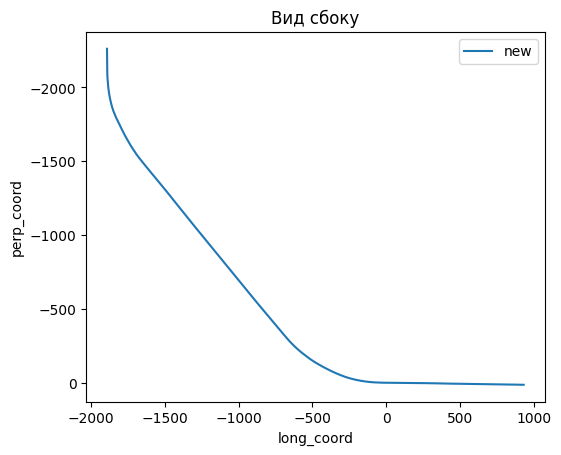

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(new_well[:, 0], new_well[:, 1], label='new')
ax.set_xlabel('long_coord')
ax.set_ylabel('perp_coord')
ax.set_title('Вид сбоку')
plt.gca().invert_yaxis()
ax.set_aspect(1)
plt.legend()
plt.show()

In [11]:
# # calc radius
# dist=np.sqrt((new_well[0,0]-R_sens0)**2+(new_well[0,1]-z_sens0)**2)
# radius_opt=dist/np.sqrt(2)
# print(radius_opt)

In [12]:
R_old = []
for i in range(inkl_data.shape[0]):
    R_old.append(calc_r(inkl_data[i,3],inkl_data[i,4]))
R_old=np.array(R_old)

TVD_ext_old=np.interp(half_well[:,1],inkl_data[:,0],inkl_data[:,1])
TVD_ext_new=np.interp(TVD_ext_old,inkl_data[:,1],new_well[:,1])

R_ext_old=np.interp(TVD_ext_old,inkl_data[:,1],R_old)
R_ext_new=np.interp(R_ext_old,R_old,new_well[:,0])

# # from scipy import interpolate

# # R_ext_old=np.interp(TVD_ext_old,inkl_data[:,1],R_old)
# # #f = interpolate.interp1d(R_old,new_well[:,0],kind='slinear')
# # #R_ext_new=f(R_ext_old)
# # R_ext_new=np.interp(R_ext_old,R_old,new_well[:,0])

# R_ext_new=[]
# for i in range(R_ext_old.shape[0]):
#     R_coord = R_ext_old[i] - R_sens0
#     R_ext_new.append((R_coord * math.cos(rad) + TVD_coord * math.sin(rad)))
# R_ext_new=np.array(R_ext_new)

# #R_ext_new=np.interp(np.arange(sens_coords_new.shape[0]),np.arange(old_well[:,0].shape[0]),new_well[:,0])
# #TVD_ext_new=np.interp(np.arange(sens_coords_new.shape[0]),np.arange(old_well[:,0].shape[0]),new_well[:,1])
# plt.plot(R_ext_new,TVD_ext_new)
# plt.gca().invert_yaxis()

In [13]:
vp, vs = 3000, 1500
radius = 50
tmod = 1
fd = 3000
Q = 50
Nd = 1
L = int(fd * tmod)
dt_space=1/2.02

sens_coords_new = []
correspond_ind = []
for i in range(half_well.shape[0]):
    depth = sensors_depths[i, 1]
    ind = np.abs(inkl_data[:, 0] - depth).argmin()
    long_sens, perp_sens = new_well[ind, 0], new_well[ind, 1]
    #sens_coords_new.append([long_sens, 0, perp_sens])
    #R_ext_new,TVD_ext_new
    sens_coords_new.append([R_ext_new[i], 0, TVD_ext_new[i]])
    correspond_ind.append(ind)

sens_coords_new = np.array(sens_coords_new)
correspond_ind = np.array(correspond_ind)

sources_coords = np.array([[0, 0, -radius], [0, 0, radius]])

Gtp_total = np.zeros((sens_coords_new.shape[0], sources_coords.shape[0], 3, 6, L))
Gtp_total_inv=np.zeros((sens_coords_new.shape[0],sources_coords.shape[0],3,6,L))

data_list = []
for num_sr in range(sources_coords.shape[0]):
    xx = sens_coords_new - sources_coords[num_sr, :]
    rs = green2.response_t(xx, T=tmod, fs=fd)
    rs.make_green(Q=Q, vp=vp, vs=vs, fp=1e7, a3=1e-5, naive=False)

    Gtp = - rs.Gtp(nD=Nd)

    #Gtp_total[:,num_sr,:,:,:]=Gtp

    Gtp_diff=np.diff(Gtp,axis=0)*dt_space
    
    Gtp_diff_inv=np.diff(Gtp[::-1,:,:,:],axis=0)*dt_space
    
    Gtp_total[:(Gtp_total.shape[0]-1),num_sr,:,:,:] = Gtp_diff
    Gtp_total[Gtp_total.shape[0]-1,num_sr,:,:,:] = Gtp_diff[Gtp_diff.shape[0]-1,:,:,:]
    
    Gtp_total_inv[:(Gtp_total_inv.shape[0]-1),num_sr,:,:,:] = Gtp_diff_inv
    Gtp_total_inv[Gtp_total_inv.shape[0]-1,num_sr,:,:,:] = Gtp_diff_inv[Gtp_diff_inv.shape[0]-1,:,:,:]
    
    Gtp_total_mean=(Gtp_total-Gtp_total_inv[::-1,:,:,:,:])/2
    
print("Done")

/work/2191079/QV.py:67: RuntimeWarning: invalid value encountered in divide
  bvw=Kw/w;


Done


Text(0, 0.5, 'perp_coord')

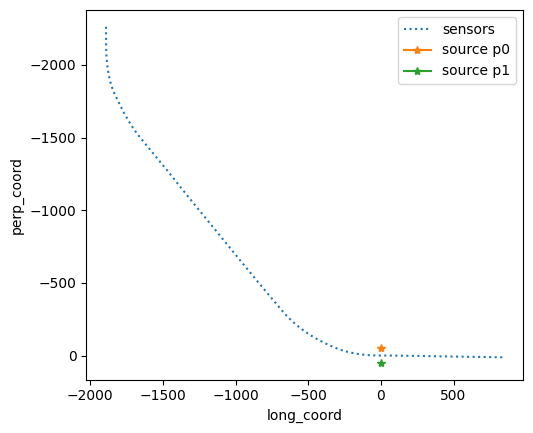

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

#ax.plot(new_well[:,0],new_well[:,1],label='well')
plt.plot(sens_coords_new[:,0],sens_coords_new[:,2],linestyle='dotted',label='sensors')
#plt.plot(R_ext_new,TVD_ext_new,linestyle='dotted')

ax.plot(sources_coords[0,0],sources_coords[0,2],marker='*',label='source p0')
ax.plot(sources_coords[1,0],sources_coords[1,2],marker='*',label='source p1')
plt.gca().invert_yaxis()
ax.set_aspect(1)
plt.legend()
ax.set_xlabel('long_coord')
ax.set_ylabel('perp_coord')

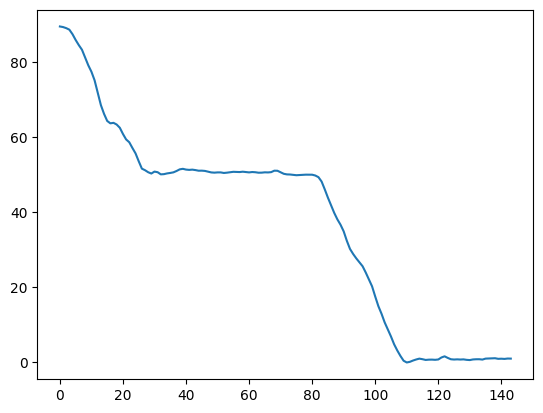

In [15]:
# ---------------angles--------------------------------------------
angles = []

for i in range(inkl_data.shape[0] - 1):
    R0, z0, R1, z1 = new_well[i, 0], new_well[i, 1], new_well[i + 1, 0], new_well[i + 1, 1]

    R0_c, z0_c, R1_c, z1_c = R_sens0, z_sens0, R_sens0, z_sens0 + radius

    well_vect = np.sqrt((R1 - R0) ** 2 + (z1 - z0) ** 2)
    cent_vect = np.sqrt((R1_c - R0_c) ** 2 + (z1_c - z0_c) ** 2)

    scalar = (R1 - R0) * (R1_c - R0_c) + (z1 - z0) * (z1_c - z0_c)

    rad = math.acos(scalar / (well_vect * cent_vect))
    # print('angle', (math.acos(scalar / (well_vect * cent_vect)) * 180) / np.pi)

    angles.append(-(rad-1.57))

angles = np.array(angles)
# -----------------------------------------------------------------
plt.plot((angles*180/np.pi))

(2001, 2, 3, 6, 3000)


Text(0.5, 1.0, 'derivative,source p0')

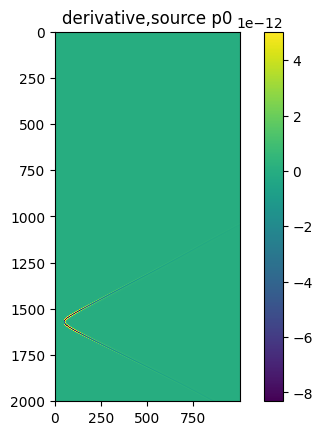

In [16]:
print(Gtp_total.shape)
coeff=100
plot_res=np.sum(Gtp_total_mean[:,0,0,:3,:1000],axis=1)
plt.imshow(plot_res,vmin=plot_res.min()/coeff,vmax=plot_res.max()/coeff)
plt.colorbar()
plt.title('derivative,source p0')

In [23]:
Gtp_total_upd=Gtp_total_mean

# NEW script
half_wave_width=160
num_channels = [0,2]
v=vp
power=11

data_list = []   # list of signals
shifts_list = [] # list of signals shifts

for s in range(Gtp_total_upd.shape[0]):

    sensor_data = np.zeros((sources_coords.shape[0], 6, 2*half_wave_width))
    shift_data = np.zeros((sources_coords.shape[0], 1), dtype = np.int16)
    
    for i_chan,chan in enumerate(num_channels):
    #for chan in num_channels:
        for source_p in range(Gtp_total_upd.shape[1]):
            
            dist=np.sqrt((sens_coords_new[s,0]-sources_coords[source_p,0])**2+(sens_coords_new[s,1]-sources_coords[source_p,1])**2+(sens_coords_new[s,2]-sources_coords[source_p,2])**2)
            tcenter=dist/v
            wave_smpl_center=tcenter*fd

            window_start = int(wave_smpl_center - half_wave_width)
            window_end = int(wave_smpl_center + half_wave_width)

            if window_end>=L:
                sensor_data[source_p, :, :] = Gtp_total_upd[s,source_p,chan,:,-2*half_wave_width:]
                shift_data[source_p,0] = int(L-2*half_wave_width)
            elif window_start<=0:
                sensor_data[source_p, :, :] = Gtp_total_upd[s,source_p,chan,:, 0:2*half_wave_width]
                shift_data[source_p,0] = int(0)
            else:
                sensor_data[source_p, :, :] = Gtp_total_upd[s,source_p,chan,:, window_start:window_end]
                shift_data[source_p,0] = window_start

        data_list.append(sensor_data*10**power) # add power coeff
        shifts_list.append(shift_data)

In [24]:
filename_new_bachata = "bachata_obj.hdf5"
fmin = 75
fmax = 300
compnts = ['xx', 'yy', 'zz', 'xy', 'xz', 'yz']
sensors = list(map(lambda x: str(int(x)), sensors_depths[:, 0]))
channels = ['X','Z']
field = np.insert(sensors_depths, 1, np.zeros(sensors_depths.shape[0]), axis=1)
xcenter, ycenter = 0, 0
domainX, domainY, domainZ = np.array([0]), np.array([0]), np.array([0])
subModelName_P = 'mod_' + str(depth_ind) + '_P'
L_win=half_wave_width*2
depth=half_well[depth_ind,1]
sub_sensors=half_well[:, 0].astype(int)
sub_sensors = list(map(lambda x: sensors.index(str(x)), sub_sensors))
sub_sensors = np.array(sub_sensors, dtype='int64')


bachata_obj_sen_P = BachataClass(filename_new_bachata, 
    data=data_list, shifts=shifts_list, subModelNames=subModelName_P, 
    data_type='window_shift_time', 
    L_win=L_win, L=L, fd=fd, fmin=fmin, fmax=fmax, components=compnts, 
    sensors=sensors, sub_sensors=sub_sensors, central_Z = depth,
    channels=channels, field=field, xcenter=xcenter, ycenter=ycenter,
    domainZ=domainZ, domainX=domainX, domainY=domainY)

#bachata_obj_sen.altitude = np.array([altitude], dtype=float) # save altitude
#bachata_obj_sen.mult_degree = np.array([10**power]) # save mult_degree

window_shift_frequency_data = bachata_obj_sen_P.get_window_shift_frequency(sensors=list(np.asarray(sensors)[sub_sensors]), channels='all', points='all', components='all', subModelName=subModelName_P)

bachata_obj_sen_P_upd = BachataClass("bachata_obj_upd.hdf5", 
data=window_shift_frequency_data, shifts=shifts_list, subModelNames=subModelName_P, 
data_type='window_shift_frequency', 
L_win=L_win, L=L, fd=fd, fmin=fmin, fmax=fmax, components=compnts, 
sensors=sensors, sub_sensors=sub_sensors, central_Z = depth,
channels=channels, field=field, xcenter=xcenter, ycenter=ycenter,
domainZ=domainZ, domainX=domainX, domainY=domainY)

print("Done")

Done


In [25]:

sigX=bachata_obj_sen_P.get_full_wave_time(sensors=sensors[:half_well.shape[0]], channels='X', subModelName=subModelName_P, points='all', components='all')
sigX=np.array(sigX)
sigX=sigX/10**power

sigZ=bachata_obj_sen_P.get_full_wave_time(sensors=sensors[:half_well.shape[0]], channels='Z', subModelName=subModelName_P, points='all', components='all')
sigZ=np.array(sigZ)
sigZ=sigZ/10**power

filt_sigX=bachata_obj_sen_P_upd.get_full_wave_time(sensors=sensors[:half_well.shape[0]], channels='X', subModelName=subModelName_P, points='all', components='all')
filt_sigX=np.array(filt_sigX)
filt_sigX=filt_sigX/10**power

filt_sigZ=bachata_obj_sen_P_upd.get_full_wave_time(sensors=sensors[:half_well.shape[0]], channels='Z', subModelName=subModelName_P, points='all', components='all')
filt_sigZ=np.array(filt_sigZ)
filt_sigZ=filt_sigZ/10**power

In [26]:
# # add white noise
# noise=np.random.normal(0, 0.0, size=sum_proj.shape)

# sigX=sigX+noise
# sigZ=sigZ+noise
# filt_sig0_noise=filt_sig0+noise

In [27]:
sum_proj=np.zeros(sigX.shape)
sum_filt_proj=np.zeros(filt_sigX.shape)

for i in range(sum_proj.shape[0]):
    sum_proj[i,:,:,:]=sigX[i,:,:,:]*(np.sin(angles[correspond_ind[i]]))+sigZ[i,:,:,:]*(np.cos(angles[correspond_ind[i]]))
    sum_filt_proj[i,:,:,:]=filt_sigX[i,:,:,:]*(np.sin(angles[correspond_ind[i]]))+filt_sigZ[i,:,:,:]*(np.cos(angles[correspond_ind[i]]))

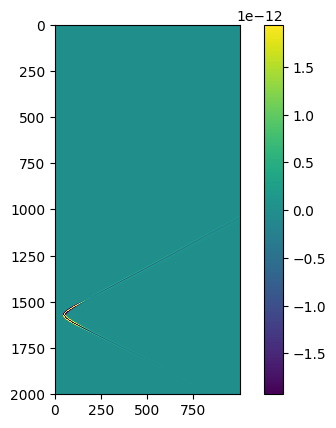

In [28]:
# TEST PLOT
coeff=1000
ch_plot=np.sum(sum_proj[:,0,:3,:1000],axis=1)
plt.imshow(ch_plot,vmin=ch_plot.min()/coeff,vmax=ch_plot.max()/coeff)
plt.colorbar()

In [29]:
sig_expl=np.sum(sum_proj[:,:,:3,:],axis=2)
sig_filt_expl=np.sum(sum_filt_proj[:,:,:3,:],axis=2)

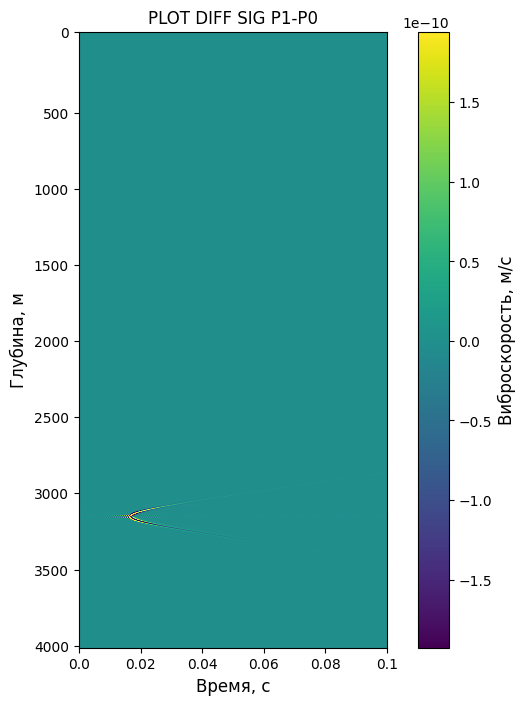

In [45]:
# PLOT DIFF SIG P1-P0
max_depth=4000
step_depth=500
depths=np.arange(0,max_depth+step_depth,step_depth)

coeff=20
tmod=0.1
time_smpls=6
smpl=int(fd*tmod)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1) 

diff_sig=sig_expl[:,0,:smpl]-sig_expl[:,1,:smpl]
im=ax.imshow(diff_sig,vmin=diff_sig.min()/coeff,vmax=diff_sig.max()/coeff)
time_ticks=(np.linspace(0,tmod*100,time_smpls).astype(int))/100
ax.set_xticks((time_ticks*fd).astype(int),time_ticks)
ax.set_yticks([np.argmin(np.abs(half_well[:,1]-dep)) for dep in depths],np.linspace(0,max_depth,depths.shape[0]).astype(int))

cax=fig.colorbar(im,fraction=0.05)
cax.set_label('Виброскорость, м/с', rotation=90,fontsize=12)
plt.title("PLOT DIFF SIG P1-P0")
plt.xlabel("Время, с",fontsize=12)
plt.ylabel("Глубина, м",fontsize=12)
plt.gca().set_aspect(0.3)

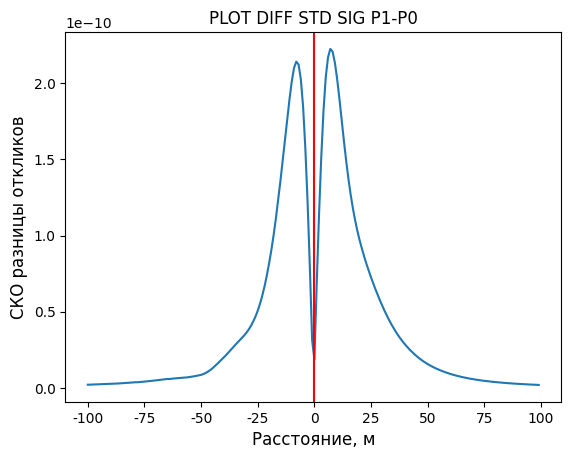

In [39]:
# PLOT DIFF STD SIG P1-P0
half_w=100
step=25
range_m=np.arange(-half_w,half_w+step,step)
#print(range_m)
std_diff_sig=np.std(diff_sig,axis=1)
xlim1,xlim2=half_well[depth_ind+range_m[0],1],half_well[depth_ind+range_m[-1],1]
#print(xlim1,xlim2)
xlim1_arg,xlim2_arg=np.argmin(np.abs(half_well[:,1]-xlim1)),np.argmin(np.abs(half_well[:,1]-xlim2))
#print(xlim1_arg,xlim2_arg)
plt.plot(std_diff_sig[xlim1_arg+1:xlim2_arg+1])
plt.axvline(half_w,color='r')
plt.xticks(np.arange(0,np.abs(range_m[0]-range_m[-1])+step,step),range_m)
plt.xlabel("Расстояние, м",fontsize=12)
plt.ylabel("СКО разницы откликов",fontsize=12)
plt.title("PLOT DIFF STD SIG P1-P0")
plt.show()

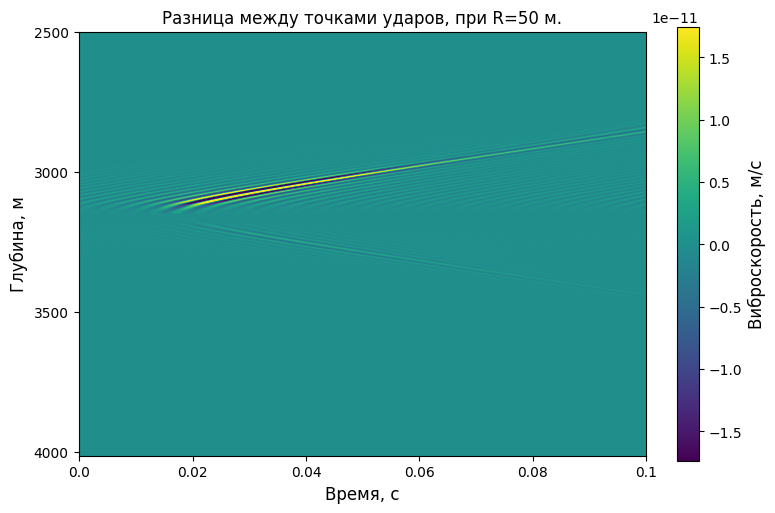

In [163]:
# PLOT DIFF FILT SIG P1-P0
max_depth=4000
step_depth=500
start_depth=2500
depths=np.arange(start_depth,max_depth+step_depth,step_depth)
ind_start_depth = np.argmin(np.abs(half_well[:,1]-start_depth))

coeff=2
tmod=0.1
time_smpls=6
smpl=int(fd*tmod)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)  

diff_filt_sig=-sig_filt_expl[ind_start_depth:,0,:smpl]-sig_filt_expl[ind_start_depth:,1,:smpl]
im=ax.imshow(diff_filt_sig,vmin=diff_filt_sig.min()/coeff,vmax=diff_filt_sig.max()/coeff)

time_ticks=(np.linspace(0,tmod*100,time_smpls).astype(int))/100
ax.set_xticks((time_ticks*fd).astype(int),time_ticks)
ax.set_yticks([np.argmin(np.abs(half_well[:,1]-dep))-ind_start_depth for dep in depths],np.linspace(start_depth,max_depth,depths.shape[0]).astype(int))

cax=fig.colorbar(im,fraction=0.035)
cax.set_label('Виброскорость, м/с', rotation=90,fontsize=12)

plt.title("Разница между точками ударов, при R="+str(radius)+" м.")
plt.xlabel("Время, с",fontsize=12)
plt.ylabel("Глубина, м",fontsize=12)
plt.gca().set_aspect(0.3)

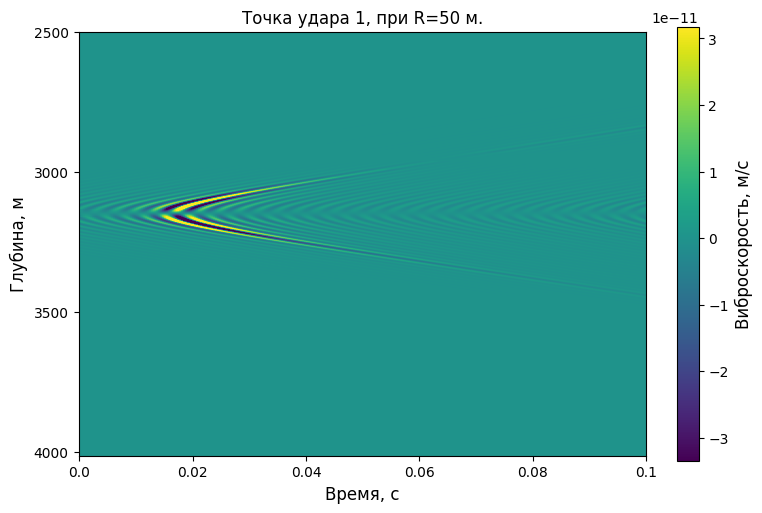

In [164]:
# PLOT FILT SIG P0
max_depth=4000
step_depth=500
start_depth=2500
depths=np.arange(start_depth,max_depth+step_depth,step_depth)
ind_start_depth = np.argmin(np.abs(half_well[:,1]-start_depth))

coeff=2
tmod=0.1
time_smpls=6
smpl=int(fd*tmod)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)  

filt_sig0=sig_filt_expl[ind_start_depth:,0,:smpl]#-sig_filt_expl[ind_start_depth:,1,:smpl]
im=ax.imshow(filt_sig0,vmin=filt_sig0.min()/coeff,vmax=filt_sig0.max()/coeff)

time_ticks=(np.linspace(0,tmod*100,time_smpls).astype(int))/100
ax.set_xticks((time_ticks*fd).astype(int),time_ticks)
ax.set_yticks([np.argmin(np.abs(half_well[:,1]-dep))-ind_start_depth for dep in depths],np.linspace(start_depth,max_depth,depths.shape[0]).astype(int))

cax=fig.colorbar(im,fraction=0.035)
cax.set_label('Виброскорость, м/с', rotation=90,fontsize=12)

plt.title("Точка удара 1, при R="+str(radius)+" м.")
plt.xlabel("Время, с",fontsize=12)
plt.ylabel("Глубина, м",fontsize=12)
plt.gca().set_aspect(0.3)

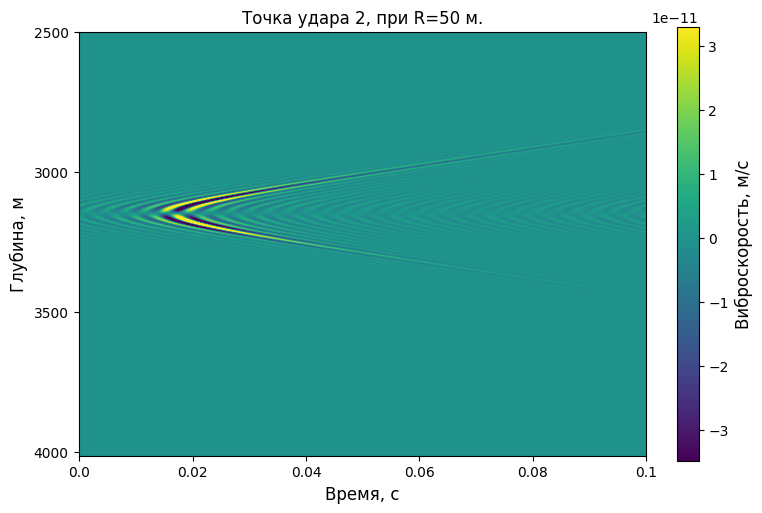

In [165]:
# PLOT FILT SIG P1
max_depth=4000
step_depth=500
start_depth=2500
depths=np.arange(start_depth,max_depth+step_depth,step_depth)
ind_start_depth = np.argmin(np.abs(half_well[:,1]-start_depth))

coeff=2
tmod=0.1
time_smpls=6
smpl=int(fd*tmod)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)  

filt_sig1=sig_filt_expl[ind_start_depth:,1,:smpl]#-sig_filt_expl[ind_start_depth:,1,:smpl]
im=ax.imshow(filt_sig1,vmin=filt_sig1.min()/coeff,vmax=filt_sig1.max()/coeff)

time_ticks=(np.linspace(0,tmod*100,time_smpls).astype(int))/100
ax.set_xticks((time_ticks*fd).astype(int),time_ticks)
ax.set_yticks([np.argmin(np.abs(half_well[:,1]-dep))-ind_start_depth for dep in depths],np.linspace(start_depth,max_depth,depths.shape[0]).astype(int))

cax=fig.colorbar(im,fraction=0.035)
cax.set_label('Виброскорость, м/с', rotation=90,fontsize=12)

plt.title("Точка удара 2, при R="+str(radius)+" м.")
plt.xlabel("Время, с",fontsize=12)
plt.ylabel("Глубина, м",fontsize=12)
plt.gca().set_aspect(0.3)

In [141]:
# s1=sig_filt_expl[:,0,:smpl]
# s2=sig_filt_expl[:,1,:smpl]
# diff=-s1-s2
# plt.plot(np.max(s1,axis=1))
# plt.plot(np.max(s2,axis=1))
# plt.plot(np.max(diff,axis=1),label='diff')
# plt.legend()
# plt.xlim([1250,1850])

In [185]:
std_diff_filt_sig[xlim1_arg+1:xlim2_arg+1].shape

(200,)

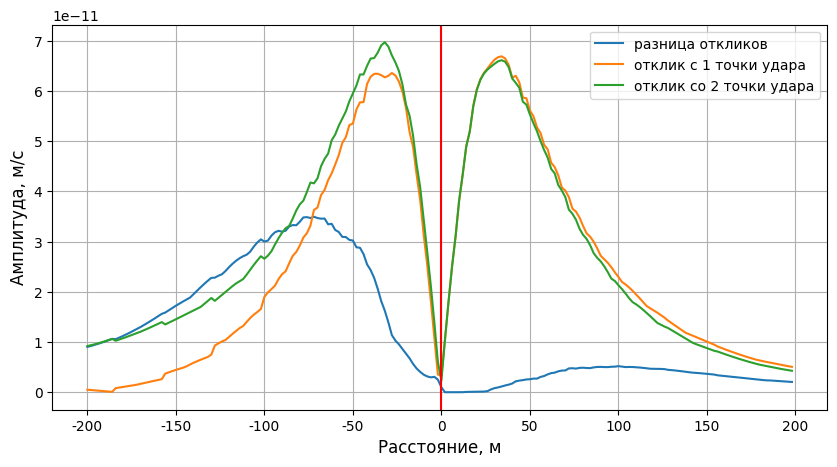

In [187]:
# PLOT DIFF FILT STD SIG P1-P0
half_w=200
step=50

range_m=np.arange(-half_w,half_w+step,step)
#print(range_m)
diff_filt_sig=np.abs(-sig_filt_expl[:,0,:smpl]-sig_filt_expl[:,1,:smpl])
std_diff_filt_sig=np.max(diff_filt_sig,axis=1)
std_filt_sig0=np.max(np.abs(sig_filt_expl[:,0,:smpl]),axis=1)
std_filt_sig1=np.max(np.abs(sig_filt_expl[:,1,:smpl]),axis=1)

xlim1,xlim2=half_well[depth_ind+int(range_m[0]/2),1],half_well[depth_ind+int(range_m[-1]/2),1]
#print(xlim1,xlim2)
xlim1_arg,xlim2_arg=np.argmin(np.abs(half_well[:,1]-xlim1)),np.argmin(np.abs(half_well[:,1]-xlim2))
#print(xlim1_arg,xlim2_arg)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)  

ax.plot(std_diff_filt_sig[xlim1_arg+1:xlim2_arg+1],label="разница откликов")
ax.plot(std_filt_sig0[xlim1_arg+1:xlim2_arg+1],label="отклик с 1 точки удара")
ax.plot(std_filt_sig1[xlim1_arg+1:xlim2_arg+1],label="отклик со 2 точки удара")

ax.axvline(half_w/2,color='r')
ax.set_xticks(np.arange(0,np.abs(range_m[0]/2-range_m[-1]/2)+step/2,step/2),range_m)
ax.set_xlabel("Расстояние, м",fontsize=12)
ax.set_ylabel("Амплитуда, м/с",fontsize=12)
plt.legend()
plt.grid()
plt.show()

(1500.0, 1700.0)

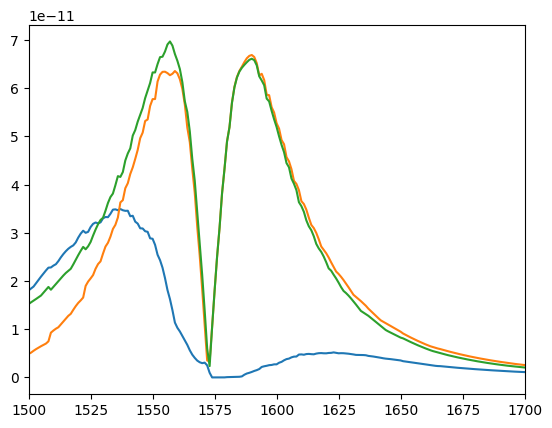

In [171]:
plt.plot(std_diff_filt_sig,label="разница откликов")
plt.plot(std_filt_sig0,label="отклик с 1 точки удара")
plt.plot(std_filt_sig1,label="отклик со 2 точки удара")
plt.xlim([1500,1700])

In [172]:
std_filt_sig0.shape

(2001,)

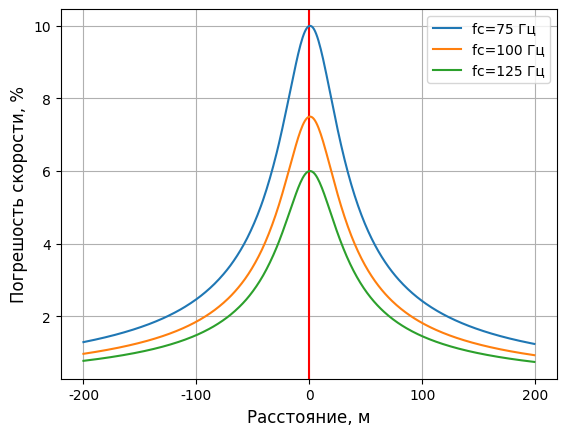

In [98]:
# fc=75,100,125
# перевести в метры от центра и скорости
# радиус 10 50 100 м
half_w=200
step=100
range_m=np.arange(-half_w,half_w+step,step)

fc=[75,100,125] 
source=sources_coords[0, :]

delta_v=np.zeros((len(fc),sens_coords_new.shape[0]))
for j,f in enumerate(fc): 
    for i in range(sens_coords_new.shape[0]):
        sens_coord=sens_coords_new[i]
        dist=np.sqrt((sens_coord[0]-source[0])**2+(sens_coord[1]-source[1])**2+(sens_coord[2]-source[2])**2)
        lambd=vp/f
        n=dist/lambd
        delta_v[j,i]=((1/(8*n))*100)
    
xlim1,xlim2=half_well[depth_ind+range_m[0],1],half_well[depth_ind+range_m[-1],1]
xlim1_arg,xlim2_arg=np.argmin(np.abs(half_well[:,1]-xlim1)),np.argmin(np.abs(half_well[:,1]-xlim2))
plt.xticks(np.arange(0,np.abs(range_m[0]-range_m[-1])+step,step),range_m)

plt.axvline(half_w,color='r')
plt.plot(delta_v[0,xlim1_arg:xlim2_arg],label="fc=75 Гц")
plt.plot(delta_v[1,xlim1_arg:xlim2_arg],label="fc=100 Гц")
plt.plot(delta_v[2,xlim1_arg:xlim2_arg],label="fc=125 Гц")

plt.xlabel("Расстояние, м",fontsize=12)
plt.ylabel('Погрешость скорости, %',fontsize=12)
plt.legend()
plt.grid()